## Imports

In [90]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.graphics import tsaplots

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import datetime

## Decomposition of Time Series

### Read the data

In [112]:
tps_df = pd.read_csv("../data/tps/train.csv")

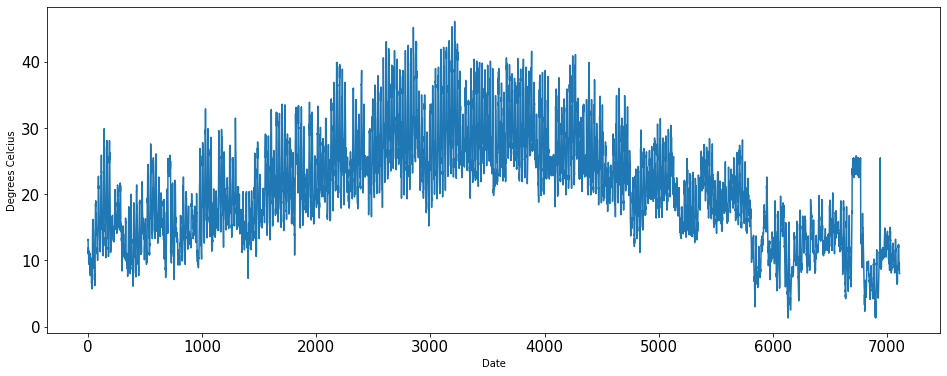

In [113]:
tps_df["deg_C"].plot(figsize=(16, 6), fontsize=15)
plt.xlabel("Date")
plt.ylabel("Degrees Celcius");

Obviously, summer months have higher temperatures, and we would expect this behavior to repeat every year. However, the human eye and its ability to detect patterns can only go so far.

For example, it might be harder to find seasonal patterns from plots such as these:

In [2]:
meat_df = pd.read_csv("https://s3.amazonaws.com/assets.datacamp.com/production/course_5226/datasets/ch4_meat.csv", 
    parse_dates=["date"], index_col="date")

In [3]:
meat_df.head()

,beef,veal,pork,lamb_and_mutton,broilers,other_chicken,turkey
date,,,,,,,
1944-01-01,751.0,85.0,1280.0,89.0,NaN,NaN,NaN
1944-02-01,713.0,77.0,1169.0,72.0,NaN,NaN,NaN
1944-03-01,741.0,90.0,1128.0,75.0,NaN,NaN,NaN
1944-04-01,650.0,89.0,978.0,66.0,NaN,NaN,NaN
1944-05-01,681.0,106.0,1029.0,78.0,NaN,NaN,NaN


Text(0, 0.5, 'Meat production (t)')

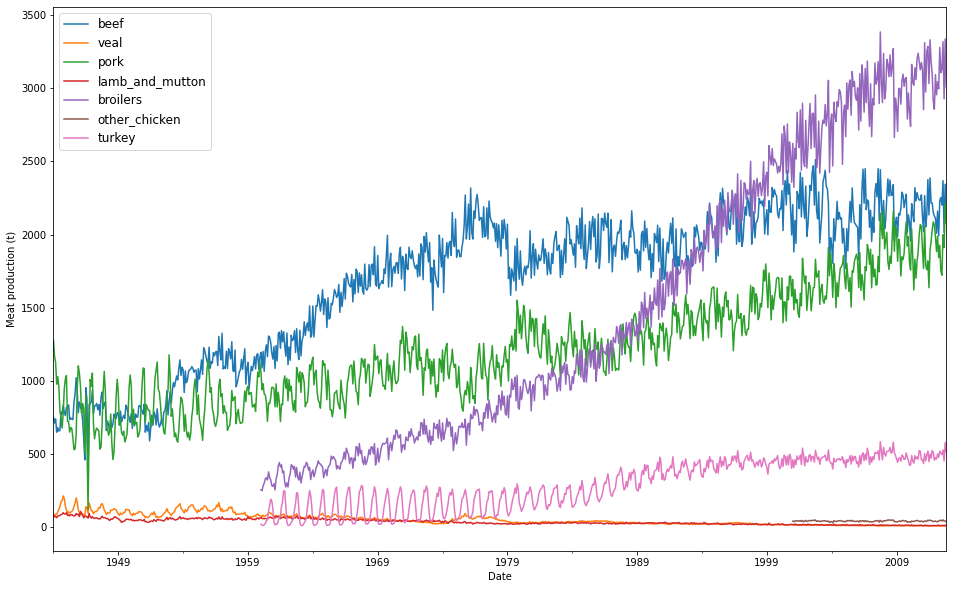

In [9]:
meat_df.plot(figsize=(16, 10))
plt.legend(fontsize="large")
plt.xlabel("Date")
plt.ylabel("Meat production (t)")

### Seasonality Analysis

To find hidden seasonal patterns from time series like above, we will use the `seasonal_decompose` function from statsmodels

<AxesSubplot:xlabel='date'>

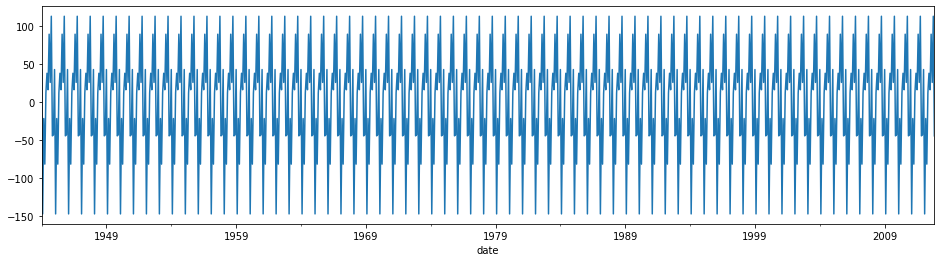

In [12]:
decomposition = sm.tsa.seasonal_decompose(meat_df["beef"])

rcParams["figure.figsize"] = 16, 4
decomposition.seasonal.plot()

Using `sm.tsa.seasonal_decompose` on 'beef' time-series returns a `DecomposeResult` object with attributes like seasonal, trend and resid (more on the last two later).

Above, we are plotting the seasonality, but the plot is not useful since it has too much noise. Let's choose an interval to give the line some room to breathe:

<AxesSubplot:xlabel='date'>

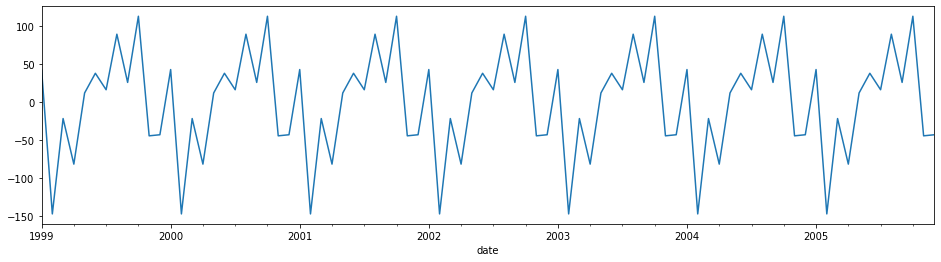

In [13]:
decomposition.seasonal["1999":"2005"].plot()

This plot shows that beef production really goes down at the beginning of each year, but it reaches its peak towards the end.

Note on `seasonal_decompose` function: it produces small figures by default. You have to control its aspects on your own and the plot function does not accept most of the regular Matplotlib parameters.

Now, let's plot the seasonality of all types of meat over a 5-year interval:

array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>]],
      dtype=object)

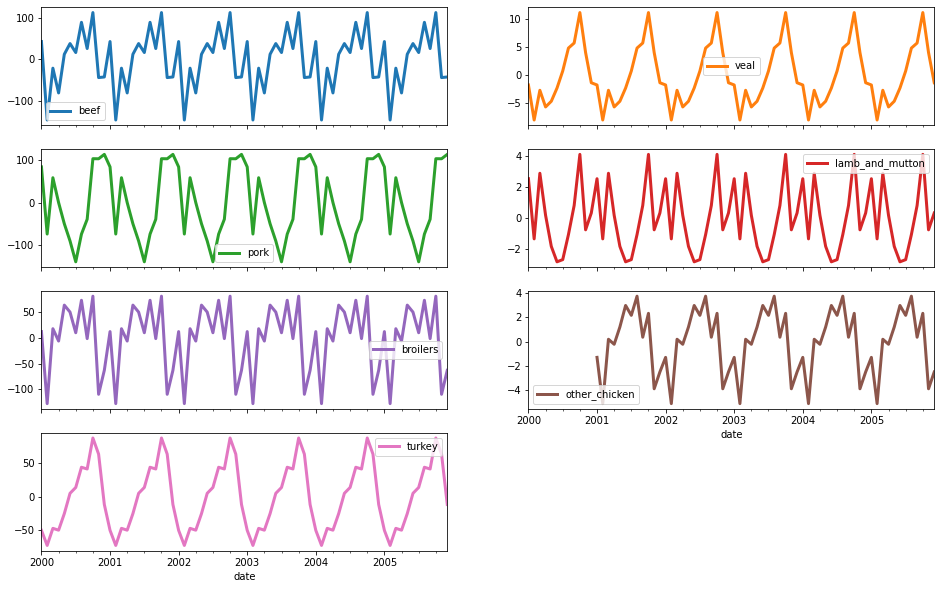

In [18]:
seasonality_dict = {}

for ts in meat_df.columns:
    decompositions = sm.tsa.seasonal_decompose(meat_df[ts].dropna())
    seasonality_dict[ts] = decompositions.seasonal
    
rcParams["figure.figsize"] = 16, 10
pd.DataFrame(seasonality_dict)["2000":"2005"].plot(subplots=True, layout=(4, 2), linewidth=3)

As can be seen, each type of meat has a different seasonality pattern.

It can be seen that broiler chicken is the meat that is most commonly consumed during the year, which makes sense when looking at the first graph comparing the evolution of all types of meat in which it was seen that this type of meat had experienced great growth compared to the rest.

As for turkey, taking into account that this is US data, it can be determined that the growth it undergoes at the end of each year is due to the Thanksgiving holiday.

A relationship can be observed between the consumption of beef, pork, and chicken in general. When beef and chicken consumption goes up (during most of the year, as they are the most commonly consumed meat types), pork consumption goes down and vice versa.

As for sheep and lamb, it can be seen that their consumption increases during the Christmas season, which makes sense as it is a food that is widely consumed during the Christmas celebrations.

### Trend Analysis

Once again, the overall trend of a time series shows whether it increased, decreased, or stayed constant (flat) over a time period. The above `DecomposeResult` object contains values that show the overall slope of a time series under the `trend` attribute.

Let's plot them for the meat production dataset:

array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>]], dtype=object)

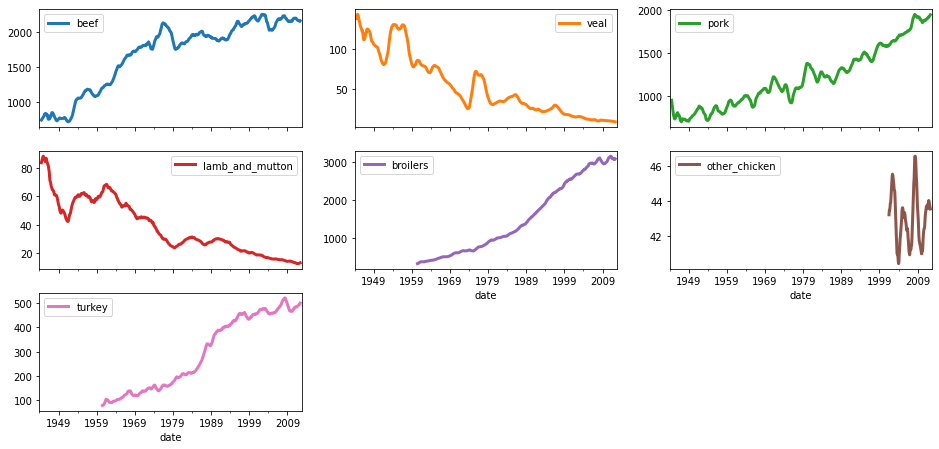

In [19]:
trend_dict = {}

for ts in meat_df.columns:
    decomposition = sm.tsa.seasonal_decompose(meat_df[ts].dropna())
    trend_dict[ts] = decomposition.trend
    
pd.DataFrame(trend_dict).plot(subplots=True, layout=(4, 3), linewidth=3)

This plot is massively insightful compared to the simple line plot we saw in the beginning. Indeed, we now see that meat from lambs and veal production has decreased dramatically since the 1940s.

This might be in part caused by the double or triple production increases in beef, broilers, and turkey. We are performing informed guesses now, but we will explore some powerful methods to validate them in later sections.

### Noise

The third component of time series is noise. There is nothing fancy about it like the other two components. It only shows random and irregular data points that could not be attributed to either seasonality or noise.

You can plot them using the `resid` attribute from the `DecomposeResult` object:

array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>]], dtype=object)

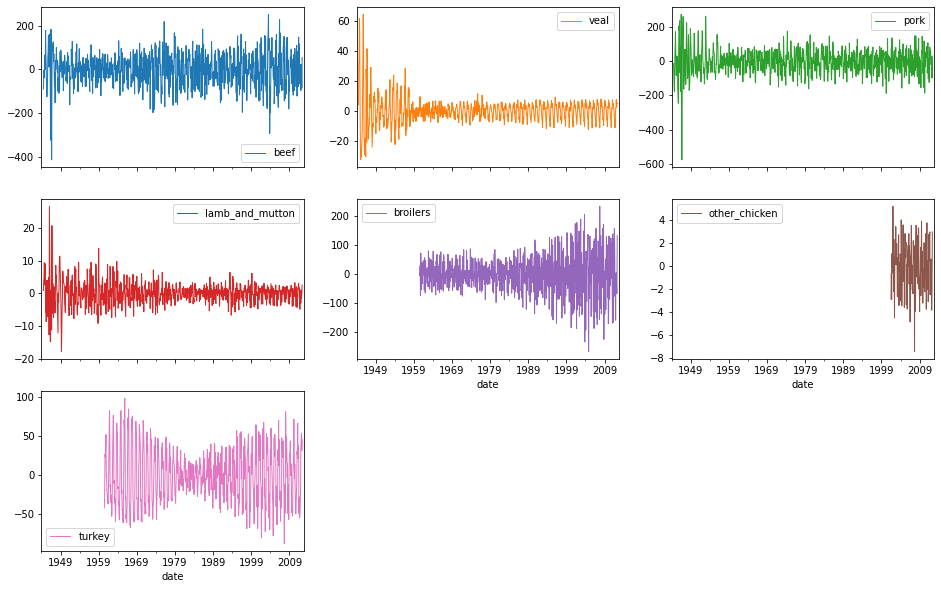

In [20]:
resid_dict = {}

for ts in meat_df.columns:
    decomposition = sm.tsa.seasonal_decompose(meat_df[ts].dropna())
    resid_dict[ts] = decomposition.resid
    
pd.DataFrame(resid_dict).plot(subplots=True, layout=(3, 3), linewidth=1)

Calling `plot` on the whole `DecomposeResult` object will produce a plot with all components displayed on the same axes.

Decomposing your times series helps you think of them in a structured manner. Instead of imagining a series as a value changing over time, you can think of it as a distribution with a particular seasonality signal or a feature with a particular slope. This level of data understanding can be a key factor during feature engineering and modeling.

## Working with Multiple Time Series 

### Generals

Working with multiple time series presents certain challenges. One example, as we saw, is the different scales each distribution comes in:m

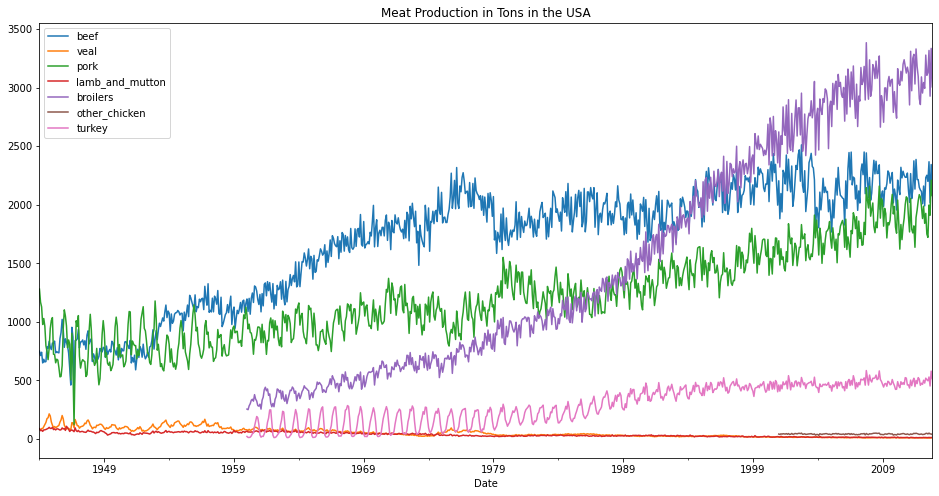

In [21]:
meat_df.plot(figsize=(16, 8), title="Meat Production in Tons in the USA")
plt.xlabel("Date");

When features with larger scales squish others to a flat line (lamb and veal), it is impossible to compare their growth. One solution is using normalization.

When normalizing time series, you divide every data point in the distribution by the first sample. This has the effect of representing every single data point as the percentage increase relative to the first sample:

In [32]:
meat_df.div(meat_df.iloc[0])

,beef,veal,pork,lamb_and_mutton,broilers,other_chicken,turkey
date,,,,,,,
1944-01-01,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN
1944-02-01,0.949401,0.905882,0.913281,0.808989,NaN,NaN,NaN
1944-03-01,0.986684,1.058824,0.881250,0.842697,NaN,NaN,NaN
1944-04-01,0.865513,1.047059,0.764062,0.741573,NaN,NaN,NaN
1944-05-01,0.906791,1.247059,0.803906,0.876404,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2012-07-01,2.930493,0.111765,1.345156,0.140449,NaN,NaN,NaN
2012-08-01,3.152463,0.118824,1.560859,0.159551,NaN,NaN,NaN
2012-09-01,2.684421,0.103529,1.492969,0.140449,NaN,NaN,NaN


The best part is now, each distribution has the same scale. Let's plot the meat production data by performing normalization:

In [60]:
first_non_null_date = {}
first_non_null_date["broilers"] = meat_df.broilers.loc[~meat_df.broilers.isnull()].index[0]
first_non_null_date["turkey"] = meat_df.turkey.loc[~meat_df.turkey.isnull()].index[0]
first_non_null_date["other_chicken"] = meat_df.other_chicken.loc[~meat_df.other_chicken.isnull()].index[0]

In [61]:
first_non_null_date

{'broilers': Timestamp('1960-01-01 00:00:00'),
 'turkey': Timestamp('1960-01-01 00:00:00'),
 'other_chicken': Timestamp('2001-01-01 00:00:00')}

In [68]:
meat_series_dict = {}
meat_series_dict["broilers"] = meat_df.loc[first_non_null_date["broilers"]:datetime.datetime(2012, 11, 1), :]["broilers"]
meat_series_dict["turkey"] = meat_df.loc[first_non_null_date["turkey"]:datetime.datetime(2012, 11, 1), :]["turkey"]
meat_series_dict["other_chicken"] = meat_df.loc[first_non_null_date["other_chicken"]:datetime.datetime(2012, 11, 1), :]["other_chicken"]

In [70]:
normalized_meat_series_dict = {}
normalized_meat_series_dict["broilers"] = meat_series_dict["broilers"].divide(meat_series_dict["broilers"].iloc[0])
normalized_meat_series_dict["turkey"] = meat_series_dict["turkey"].divide(meat_series_dict["turkey"].iloc[0])
normalized_meat_series_dict["other_chicken"] = meat_series_dict["other_chicken"].divide(meat_series_dict["other_chicken"].iloc[0])

In [72]:
pd.DataFrame(normalized_meat_series_dict)

,broilers,turkey,other_chicken
date,,,
1960-01-01,1.000000,1.000000,NaN
1960-02-01,0.980461,0.633484,NaN
1960-03-01,1.108245,0.606335,NaN
1960-04-01,1.178585,0.733032,NaN
1960-05-01,1.296209,1.226244,NaN
...,...,...,...
2012-07-01,12.219617,22.497738,1.016393
2012-08-01,12.963658,23.986425,1.194379
2012-09-01,11.438453,20.502262,1.023419


In [ ]:
for ts in meat_df:
    
normalized_full =

Text(0, 0.5, 'Increase (%)')

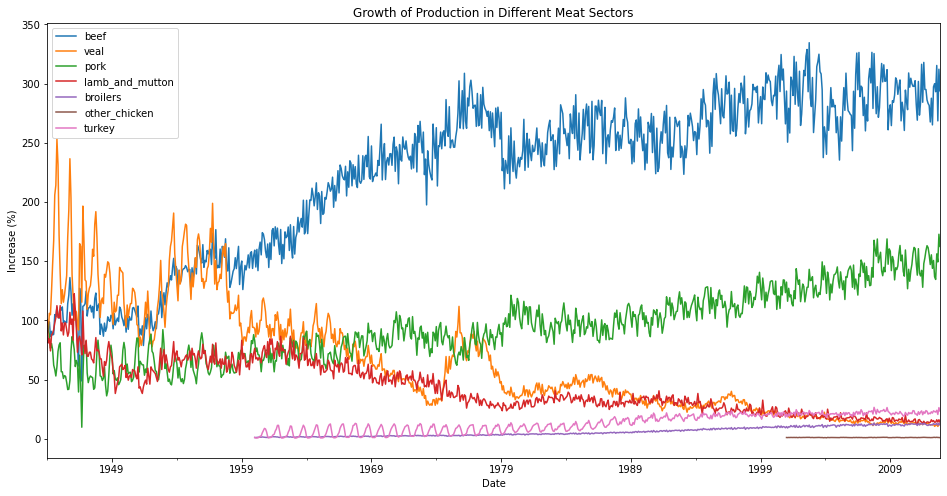

In [81]:
normalized = meat_df.div(meat_df.iloc[0]).mul(100)
normalized.update(pd.DataFrame(normalized_meat_series_dict))

normalized.plot(figsize=(16, 8), title="Growth of Production in Different Meat Sectors")
plt.xlabel("Date")
plt.ylabel("Increase (%)")

Beef and pork saw the highest percentage increases while veal and lamb meat production plummeted over the given time period.

### Relationships between time series with correlation

A simple correlation heatmap can indeed tell a lot about the linear relationships between variables:

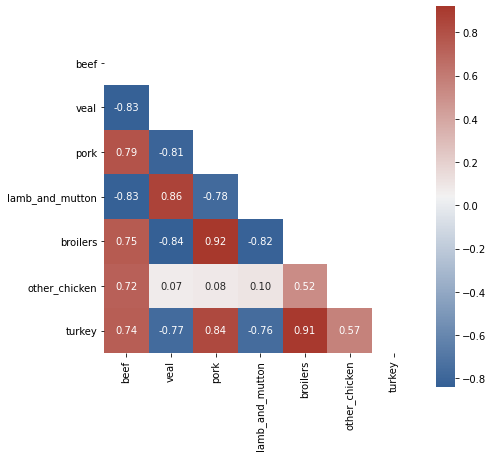

In [84]:
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

matrix = meat_df.corr(method="pearson")

mask = np.triu(np.ones_like(matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.show()

What we are more interested in is how underlying components of time series affect each other. For example, let's see how the seasonality of each time series influences others:

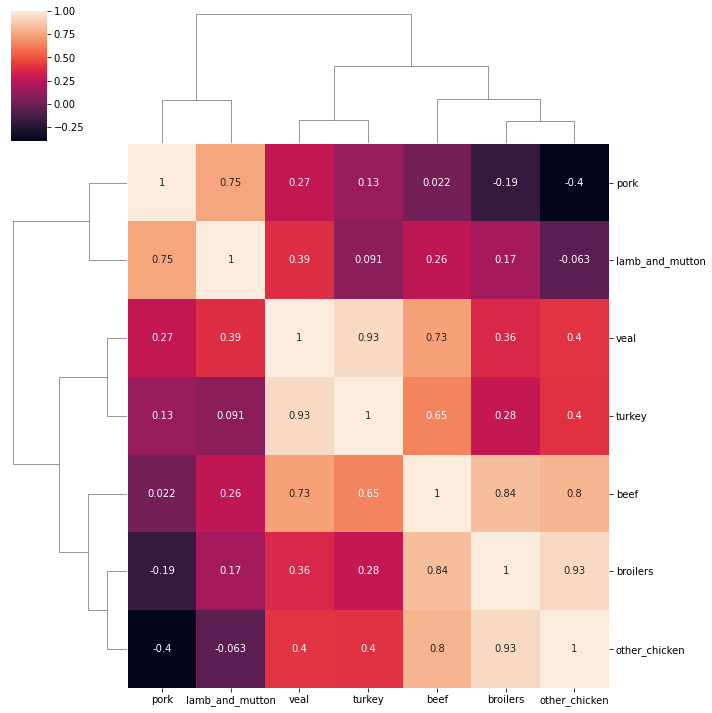

In [86]:
seasonality_dict = {
    ts: sm.tsa.seasonal_decompose(meat_df[ts].dropna()).seasonal for ts in meat_df.columns
}

seasonality_corr = pd.DataFrame(seasonality_dict).corr()

sns.clustermap(seasonality_corr, annot=True, square=True)
plt.show()

This time, we are using a ClusterMap rather than a heatmap to see closely correlated groups with the help of dendrograms immediately.

The plot tells us that the seasonality of beef, broilers, and other chicken meats are heavily correlated. The same is true with pork and lamb/mutton meats. This positive correlation can be indicative of close seasonality matches.

For example, it is possible that increase/decrease patterns of beef, broilers, and other chicken meats often matched over the given period.

Let's do the same for trends, which I think should be more interesting:

/Users/Administrador/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:1215: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


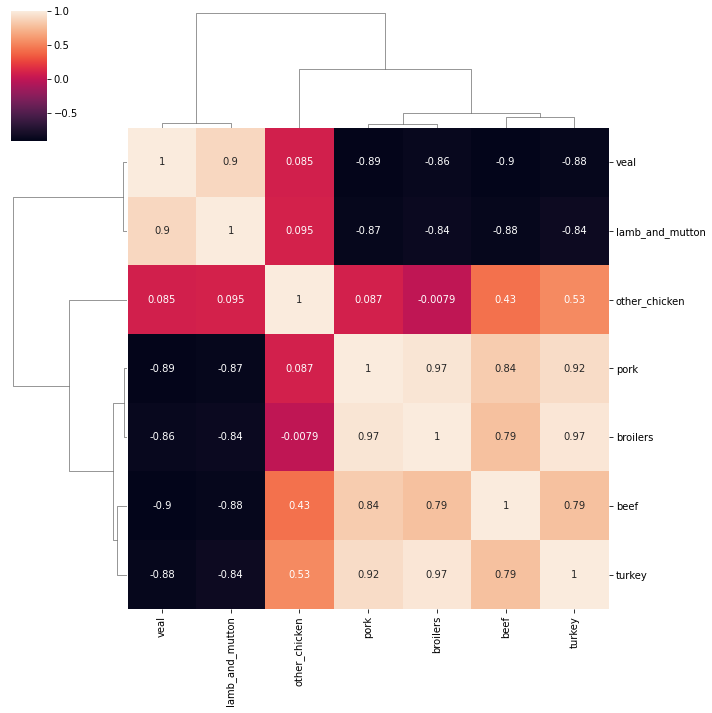

In [88]:
trend_dict = {
    ts: sm.tsa.seasonal_decompose(meat_df[ts].dropna()).trend for ts in meat_df.columns
}

# Compute corr matrix
trend_dict = pd.DataFrame(trend_dict).corr()

sns.clustermap(trend_dict, annot=True, square=True)
plt.show();

The above plot is awesome because it helps us validate our assumptions in the trend analysis section. Let's look at the normalized plot of meat production once again:

Text(0, 0.5, 'Increase (%)')

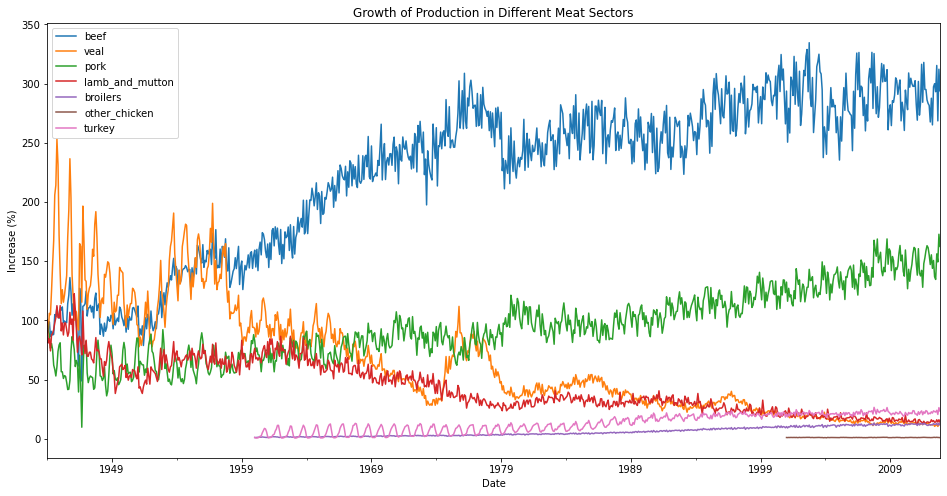

In [89]:
normalized.plot(figsize=(16, 8), title="Growth of Production in Different Meat Sectors")
plt.xlabel("Date")
plt.ylabel("Increase (%)")

Can you match the patterns in the cluster map to the line plot? For example, beef has strong negative correlations with lamb/mutton and veal. This is matched by the fact that beef production tripled in amount while the production of the other two decreased by ~75% (seen from the line plot).

The same observations can be made between pork and veal, lamb/mutton.

### Correlation does not mean causation

I want you to tread carefully when making assumptions about correlated features. Always remember that correlation does not mean causation. When two features are heavily correlated, it does not mean an increase in one causes an increase in another.

An example I like to use is that even though the number of storks in a town can correlate with the number of newborn babies, it does not mean that storks deliver the babies.

## Autocorrelation and partial autocorrelation

### Autocorrelation

Autocorrelation is a powerful analysis tool for modeling time series data. As the name suggests, it involves computing the correlation coefficient. But here, rather than computing it between two features, correlation of a time series is found with a lagging version of itself.

Let's first look at an example plot and explain further:

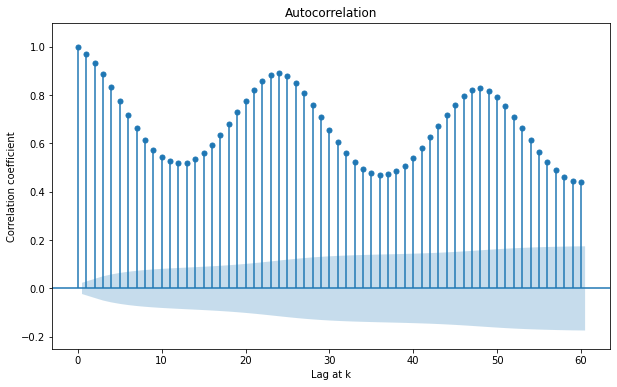

In [102]:
rcParams["figure.figsize"] = 10, 6

# Stands for Time Series Analysis Plots (TSA Plots)
fig = tsaplots.plot_acf(tps_df["deg_C"], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.ylim([-.25, 1.1])
plt.show()

The XAxis of an autocorrelation function plot (ACF) is the lag number k. For example, when k=1, the correlation is found by shifting the series by 1. This is the same as using the shift function of Pandas:

In [94]:
beef = meat_df["beef"].to_frame(name="beef")

beef["lag_1"] = beef["beef"].shift(periods=1)
beef["lag_2"] = beef["beef"].shift(periods=2)
beef["lag_3"] = beef["beef"].shift(periods=3)

beef.head()

,beef,lag_1,lag_2,lag_3
date,,,,
1944-01-01,751.0,NaN,NaN,NaN
1944-02-01,713.0,751.0,NaN,NaN
1944-03-01,741.0,713.0,751.0,NaN
1944-04-01,650.0,741.0,713.0,751.0
1944-05-01,681.0,650.0,741.0,713.0


The YAXis is the amount of correlation at each lag k. The shaded blue region is a confidence interval - if the height of the bars is outside this region, it means the correlation is statistically significant.

They offer an alternative way of detecting patterns and seasonality. For example, the ACF plot of temperature in Celcius shows that the correlation at every 15 lags decreases or every 25 lags increases.

When a clear trend exists in a time series, the autocorrelation tends to be high at small lags like 1 or 2. When seasonality exists, the autocorrelation goes up periodically at larger lags.

Let's look at another example:

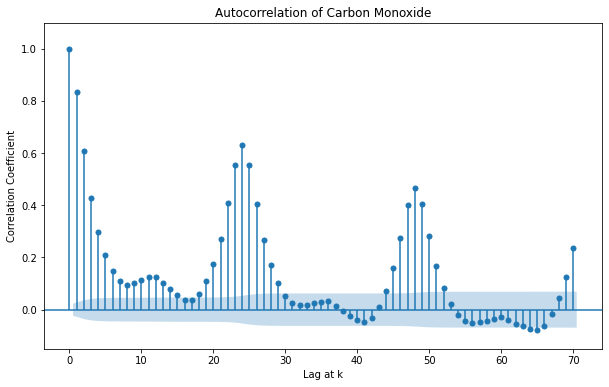

In [106]:
fig = tsaplots.plot_acf(tps_df["target_carbon_monoxide"], lags=70)

plt.title("Autocorrelation of Carbon Monoxide")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.ylim([-.15, 1.1])
plt.show();

The ACF of carbon monoxide confirms that small lags tend to have high correlations. It also shows that every 25 lags, the correlation increases significantly but quickly drops down to the negative. But most of the downward bars are inside the shaded area, suggesting that they are not statistically significant.

This ability to compare the relationship between past and present data points present a unique advantage. If you can associate the present value to points k periods before, this also means you can find a link to values that come after k periods.

Besides, understanding autocorrelation is key to modeling time series with ARIMA models.

### Partial autocorrelation

It is similar to autocorrelation - it is calculated using the series and its lagged version at k:

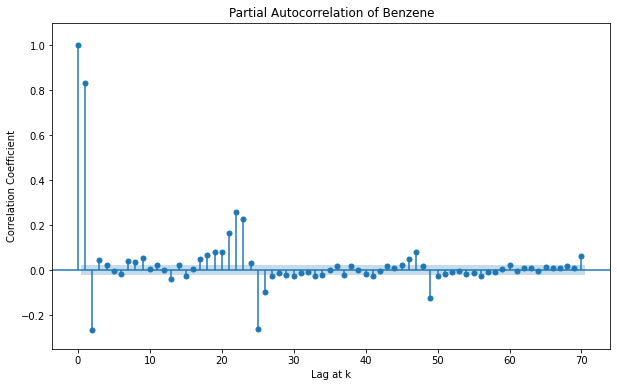

In [110]:
fig = tsaplots.plot_pacf(tps_df["target_benzene"], lags=70)

plt.title("Partial Autocorrelation of Benzene")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.ylim([-.35, 1.1])
plt.show();

The only difference is that this method tries to account for the effect the intervening lags have. For example, at lag 3, partial autocorrelation removes the effect lags 1 and 2 have on computing the correlation.

While autocorrelation is useful for analyzing a time series's properties and choosing what type of ARIMA model to use, partial autocorrelation tells what order of autoregressive model to fit.